# Text–Motion Retrieval — Version TMR Paper + MLflow

**Améliorations majeures:**
1. Text encoder du papier (DistilBERT au lieu de CLIP)
2. Loss T-EMOS du papier: LR + λKL⋅LKL + λE⋅LE
3. Hyperparamètres du papier TMR
4. MLflow tracking complet
5. Anti-overfitting renforcé

## 0. CONFIGURATION CENTRALE

In [94]:
# ════════════════════════════════════════════════════════════════════════════════
# CONFIGURATION - Basée sur le papier TMR
# ════════════════════════════════════════════════════════════════════════════════

class Config:
    """Configuration basée sur le papier TMR/T-EMOS"""
    
    # ── CHEMINS ──────────────────────────────────────────────────────────────────
    DATA_ROOT = './data/'
    SAVE_DIR = './checkpoints/'
    MLFLOW_TRACKING_URI = './mlruns'  # Dossier local MLflow
    MLFLOW_EXPERIMENT_NAME = 'text-motion-retrieval'
    
    # ── TEXT ENCODER ─────────────────────────────────────────────────────────────
    # Options: 'clip', 'distilbert' (TMR paper)
    TEXT_ENCODER_TYPE = 'distilbert'  # ← Comme dans le papier TMR
    DISTILBERT_MODEL = 'distilbert-base-uncased'
    FREEZE_TEXT_ENCODER = False  # Fine-tune le text encoder
    
    # ── MOTION ENCODER ───────────────────────────────────────────────────────────
    # Options: 'lstm', 'transformer', 'vae', 'lstm_vae'
    MOTION_MODEL_TYPE = 'transformer'  # Papier utilise Transformer
    
    # ── DIMENSIONS ───────────────────────────────────────────────────────────────
    MOTION_DIM = 384
    EMBED_DIM = 256         # Papier TMR utilise 256
    MAX_SEQ_LEN = 196       # Papier TMR: 196 frames
    
    # ── ARCHITECTURE: TRANSFORMER (Papier TMR) ───────────────────────────────────
    TRANS_NHEAD = 8         # Papier: 8 heads
    TRANS_NUM_LAYERS = 4    # Papier: 4 layers
    TRANS_DIM_FEEDFORWARD = 512  # Papier: 1024
    
    # ── ARCHITECTURE: LSTM (Alternative) ─────────────────────────────────────────
    LSTM_HIDDEN_DIM = 512
    LSTM_NUM_LAYERS = 2
    LSTM_BIDIRECTIONAL = True
    
    # ── ARCHITECTURE: VAE ────────────────────────────────────────────────────────
    VAE_LATENT_DIM = 128
    VAE_HIDDEN_DIMS = [512, 256]
    
    # ── LOSS T-EMOS (Papier) ─────────────────────────────────────────────────────
    # L_TEMOS = L_R + λ_KL * L_KL + λ_E * L_E
    USE_TEMOS_LOSS = True   # Utiliser la loss du papier
    LAMBDA_KL = 1e-5        # Poids KL divergence (papier: 1e-5)
    LAMBDA_EXTRA = 0.1      # Poids loss extra (reconstruction, etc.)
    
    # Loss contrastive
    CONTRASTIVE_LOSS_TYPE = 'infonce'  # 'infonce', 'ntxent', 'triplet'
    TEMPERATURE = 0.05      # Papier TMR: 0.05 (plus strict que 0.07)
    
    # ── RÉGULARISATION (ANTI-OVERFITTING AGRESSIF) ───────────────────────────────
    DROPOUT = 0.6           # Augmenté à 0.5 (était 0.3)
    WEIGHT_DECAY = 1e-3     # Augmenté à 5e-3 (était 1e-3)
    GRAD_CLIP = 0.5         # Plus strict (était 1.0)
    LABEL_SMOOTHING = 0.1   # Label smoothing pour la loss
    
    # Augmentation de données (RENFORCÉE)
    USE_TIME_MASKING = True
    TIME_MASK_PROB = 0.25   # Augmenté (était 0.15)
    USE_NOISE_INJECTION = True
    NOISE_STD = 0.01        # Augmenté (était 0.01)
    USE_TEMPORAL_SHIFT = True  # NOUVEAU
    TEMPORAL_SHIFT_MAX = 20    # Décalage temporel max
    
    # ── DUPLICATION DES MOTIONS ──────────────────────────────────────────────────
    DUPLICATE_MOTIONS = True  # ACTIVÉ par défaut (plus de données)
    
    # ── ENTRAÎNEMENT (Papier TMR) ────────────────────────────────────────────────
    BATCH_SIZE = 32         # Papier: 64
    EPOCHS = 20            # Plus d'epochs avec early stopping
    LEARNING_RATE = 1e-4    # Papier: 1e-4
    
    # Scheduler
    USE_WARMUP = True       # Warmup pour stabiliser
    WARMUP_EPOCHS = 5
    SCHEDULER_TYPE = 'cosine'  # 'cosine', 'onecycle'
    
    # Early stopping
    PATIENCE = 5           # Plus de patience
    MIN_DELTA = 1e-4
    
    # ── VALIDATION ───────────────────────────────────────────────────────────────
    VAL_SPLIT = 0.2
    N_VIZ_SAMPLES = 100
    VIZ_EVERY_N_EPOCHS = 2
    
    # ── MLFLOW ───────────────────────────────────────────────────────────────────
    LOG_EVERY_N_STEPS = 10  # Log metrics tous les N steps
    LOG_MODEL = True        # Sauvegarder le modèle dans MLflow
    
    # ── RANDOM SEED ──────────────────────────────────────────────────────────────
    RANDOM_SEED = 42
    
    @classmethod
    def print_config(cls):
        print("\n" + "="*80)
        print("📋 CONFIGURATION (Basée sur papier TMR)")
        print("="*80)
        print(f"Text Encoder: {cls.TEXT_ENCODER_TYPE.upper()}")
        print(f"Motion Encoder: {cls.MOTION_MODEL_TYPE.upper()}")
        print(f"Loss: {'T-EMOS' if cls.USE_TEMOS_LOSS else 'Standard'}")
        print(f"Embed Dim: {cls.EMBED_DIM}")
        print(f"Max Seq Len: {cls.MAX_SEQ_LEN}")
        print(f"Batch Size: {cls.BATCH_SIZE}")
        print(f"Learning Rate: {cls.LEARNING_RATE:.0e}")
        print(f"Dropout: {cls.DROPOUT}")
        print(f"Weight Decay: {cls.WEIGHT_DECAY:.0e}")
        print(f"Temperature: {cls.TEMPERATURE}")
        print(f"Duplication: {cls.DUPLICATE_MOTIONS}")
        if cls.USE_TEMOS_LOSS:
            print(f"λ_KL: {cls.LAMBDA_KL:.0e}")
            print(f"λ_E: {cls.LAMBDA_EXTRA}")
        print("="*80 + "\n")

Config.print_config()


📋 CONFIGURATION (Basée sur papier TMR)
Text Encoder: DISTILBERT
Motion Encoder: TRANSFORMER
Loss: T-EMOS
Embed Dim: 256
Max Seq Len: 196
Batch Size: 32
Learning Rate: 1e-04
Dropout: 0.6
Weight Decay: 1e-03
Temperature: 0.05
Duplication: True
λ_KL: 1e-05
λ_E: 0.1



## 1. Imports et MLflow Setup

In [95]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import csv
import gc
import pickle
from os.path import join as pjoin
from datetime import datetime
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import tqdm

# Text encoders
import open_clip
from transformers import DistilBertModel, DistilBertTokenizer

# PyTorch
from torch.utils.data import Dataset, DataLoader

# MLflow
import mlflow
import mlflow.pytorch

# Info NCE (si disponible)
try:
    from info_nce import InfoNCE
    HAS_INFO_NCE = True
except:
    HAS_INFO_NCE = False
    print("⚠️  info_nce not installed, using custom implementation")

# Setup seeds
torch.manual_seed(Config.RANDOM_SEED)
np.random.seed(Config.RANDOM_SEED)
random.seed(Config.RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Config.RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

gc.collect()
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nDevice: {device}")

from IPython import display as IPython_display
import ipywidgets as widgets
from IPython.display import display as ipy_display
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
%matplotlib inline

# Créer dossiers
os.makedirs(Config.SAVE_DIR, exist_ok=True)
os.makedirs(Config.MLFLOW_TRACKING_URI, exist_ok=True)

print("✓ Imports chargés")


Device: cuda
✓ Imports chargés


In [96]:
# ════════════════════════════════════════════════════════════════════════════════
# MLFLOW SETUP
# ════════════════════════════════════════════════════════════════════════════════

mlflow.set_tracking_uri(Config.MLFLOW_TRACKING_URI)
mlflow.set_experiment(Config.MLFLOW_EXPERIMENT_NAME)

# Créer un run name unique
RUN_NAME = f"{Config.TEXT_ENCODER_TYPE}_{Config.MOTION_MODEL_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

print(f"\n📊 MLflow configuré")
print(f"   Tracking URI: {Config.MLFLOW_TRACKING_URI}")
print(f"   Experiment: {Config.MLFLOW_EXPERIMENT_NAME}")
print(f"   Run name: {RUN_NAME}")
print(f"\n💡 Pour voir les résultats: mlflow ui --backend-store-uri {Config.MLFLOW_TRACKING_URI}")


📊 MLflow configuré
   Tracking URI: ./mlruns
   Experiment: text-motion-retrieval
   Run name: distilbert_transformer_20260219_132601

💡 Pour voir les résultats: mlflow ui --backend-store-uri ./mlruns


## 2. Fonctions de visualisation (INCHANGÉES)

In [97]:
kinematic_chain = [
    [0, 2, 5, 8, 11],
    [0, 1, 4, 7, 10],
    [0, 3, 6, 9, 12, 15],
    [9, 14, 17, 19, 21],
    [9, 13, 16, 18, 20]
]

def plot_3d_motion(save_path, kinematic_tree, mp_joints, title, figsize=(10, 10), fps=30, radius=4):
    from matplotlib.animation import FuncAnimation
    from mpl_toolkits.mplot3d import Axes3D
    
    title_sp = title.split(' ')
    if len(title_sp) > 20:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:20]), ' '.join(title_sp[20:])])
    elif len(title_sp) > 10:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:])])

    def init():
        ax.set_xlim3d([-radius / 4, radius / 4])
        ax.set_ylim3d([0, radius / 2])
        ax.set_zlim3d([0, radius / 2])
        fig.suptitle(title, fontsize=20)
        ax.grid(b=False)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    init()

    mp_data = []
    frame_number = min([data.shape[0] for data in mp_joints])
    colors = ['red', 'green', 'black', 'red', 'blue',
              'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue',
              'darkred', 'darkred', 'darkred', 'darkred', 'darkred']
    mp_colors = [[colors[i]] * 15 for i in range(len(mp_joints))]

    for joints in mp_joints:
        data = joints.copy().reshape(len(joints), -1, 3)
        MINS = data.min(axis=0).min(axis=0)
        data[:, :, 1] -= MINS[1]
        mp_data.append({"joints": data})

    def update(index):
        for line in ax.lines:
            line.remove()
        for collection in ax.collections:
            collection.remove()
        ax.view_init(elev=120, azim=-90)
        for pid, data in enumerate(mp_data):
            for i, (chain, color) in enumerate(zip(kinematic_tree, mp_colors[pid])):
                linewidth = 4.0 if i < 5 else 2.0
                ax.plot3D(
                    data["joints"][index, chain, 0],
                    data["joints"][index, chain, 1],
                    data["joints"][index, chain, 2],
                    linewidth=linewidth, color=color
                )
        ax.set_axis_off()

    ani = FuncAnimation(fig, update, frames=frame_number, interval=1000 / fps, repeat=False)
    ani.save(save_path, fps=fps)
    plt.close()
    print(f'Animation sauvegardée : {save_path}')

## 3. Fonction d'évaluation (INCHANGÉE)

In [98]:
def eval_recall(gt_df, pred_df, verbose=False):
    """Calcule le score Recall@K pondéré (K = 1..10)."""
    ks = list(range(1, 11))
    rank_cols = list(pred_df.columns)
    gt = gt_df["candidate"].values
    preds = pred_df[rank_cols].values
    assert len(gt) == len(preds), "Taille gt / preds incompatible"

    recalls = {k: 0 for k in ks}
    n = len(gt)
    for i in range(n):
        for k in ks:
            if gt[i] in preds[i, :k]:
                recalls[k] += 1
    for k in ks:
        recalls[k] /= n

    weights = {k: 1.0 / k for k in ks}
    weight_sum = sum(weights.values())
    final_score = sum(weights[k] * recalls[k] for k in ks) / weight_sum

    if verbose:
        for k, val in recalls.items():
            print(f'k={k} => recall@{k}={round(val, 3)}')
    return final_score

## 4. Génération val batches (INCHANGÉE)

In [99]:
def generate_val_batches(data_root, save_dir, batch_size, num_batches):
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(data_root, 'train.txt')) as fd:
        train_fnames = fd.read().strip().split('\n')

    random_fnames = random.sample(train_fnames, k=batch_size * num_batches)
    random_batches = np.array(random_fnames).reshape(num_batches, batch_size)

    gt = [['query_id', 'candidate']]
    for file_idx, batch in enumerate(random_batches, start=1):
        os.makedirs(pjoin(save_dir, str(file_idx)), exist_ok=True)
        rdm_idx = random.randint(0, len(batch) - 1)
        random_text_fname = batch[rdm_idx]

        with open(pjoin(data_root, 'texts', random_text_fname + '.txt')) as fd:
            file_texts = fd.read().strip().split('\n')
            random_text = random.choice(file_texts)

        with open(pjoin(save_dir, str(file_idx), 'text.txt'), 'w') as fw:
            fw.write(random_text)

        for motion_idx, fname in enumerate(batch, start=1):
            if fname == random_text_fname:
                gt.append([file_idx, motion_idx])
            motion = np.load(pjoin(data_root, 'motions', fname + '.npy'))
            np.save(pjoin(save_dir, str(file_idx), f'motion_{motion_idx}.npy'), motion)

    with open(pjoin(save_dir, 'gt.csv'), 'w', newline='') as f:
        csv.writer(f).writerows(gt)
    print(f'Val batches sauvegardés dans {save_dir}')

data_root = Config.DATA_ROOT
save_dir = pjoin(Config.DATA_ROOT, 'val/')
if not os.path.exists(pjoin(save_dir, 'gt.csv')):
    generate_val_batches(data_root, save_dir, batch_size=32, num_batches=30)

## 5. TEXT ENCODERS (CLIP + DistilBERT du papier)

In [100]:
# ════════════════════════════════════════════════════════════════════════════════
# TEXT ENCODERS
# ════════════════════════════════════════════════════════════════════════════════

class DistilBertTextEncoder(nn.Module):
    """
    Text encoder basé sur DistilBERT (comme dans le papier TMR).
    Plus léger et souvent meilleur que CLIP pour le texte.
    """
    def __init__(self, output_dim=256, freeze=False, dropout=0.1):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(Config.DISTILBERT_MODEL)
        self.bert_dim = self.bert.config.hidden_size  # 768
        
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        # Projection vers l'espace partagé
        self.projection = nn.Sequential(
            nn.Linear(self.bert_dim, output_dim * 2),
            nn.LayerNorm(output_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(output_dim * 2, output_dim)
        )
    
    def forward(self, input_ids, attention_mask):
        # BERT encoding
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Utiliser [CLS] token (première position)
        cls_output = outputs.last_hidden_state[:, 0, :]  # (B, 768)
        
        # Projection
        return self.projection(cls_output)


def create_text_encoder():
    """
    Crée le text encoder selon Config.
    Retourne (encoder, tokenizer, tokenize_function)
    """
    print(f"\n📝 Création text encoder: {Config.TEXT_ENCODER_TYPE.upper()}")
    
    if Config.TEXT_ENCODER_TYPE == 'distilbert':
        encoder = DistilBertTextEncoder(
            output_dim=Config.EMBED_DIM,
            freeze=Config.FREEZE_TEXT_ENCODER,
            dropout=Config.DROPOUT
        ).to(device)
        
        tokenizer = DistilBertTokenizer.from_pretrained(Config.DISTILBERT_MODEL)
        
        def tokenize_fn(texts):
            return tokenizer(
                texts,
                padding=True,
                truncation=True,
                max_length=77,  # Comme CLIP
                return_tensors='pt'
            )
        
        print(f"   DistilBERT chargé")
        print(f"   Freeze: {Config.FREEZE_TEXT_ENCODER}")
    
    elif Config.TEXT_ENCODER_TYPE == 'clip':
        clip_model, _, _ = open_clip.create_model_and_transforms(
            'ViT-B-32', 
            pretrained='laion2b_s34b_b79k'
        )
        
        # Wrapper pour avoir une interface uniforme
        class CLIPTextWrapper(nn.Module):
            def __init__(self, clip_model, output_dim):
                super().__init__()
                self.clip = clip_model
                self.projection = nn.Linear(512, output_dim) if output_dim != 512 else nn.Identity()
            
            def forward(self, input_ids, attention_mask=None):
                # CLIP attend juste les tokens
                feats = self.clip.encode_text(input_ids)
                return self.projection(feats.float())
        
        encoder = CLIPTextWrapper(clip_model, Config.EMBED_DIM).to(device)
        
        if Config.FREEZE_TEXT_ENCODER:
            for param in encoder.clip.parameters():
                param.requires_grad = False
        
        tokenizer = open_clip.get_tokenizer('ViT-B-32')
        
        def tokenize_fn(texts):
            tokens = tokenizer(texts)
            return {'input_ids': tokens, 'attention_mask': None}
        
        print(f"   CLIP chargé")
    
    else:
        raise ValueError(f"Unknown text encoder: {Config.TEXT_ENCODER_TYPE}")
    
    total_params = sum(p.numel() for p in encoder.parameters())
    trainable_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
    print(f"   Paramètres: {total_params:,} (entraînables: {trainable_params:,})")
    
    return encoder, tokenizer, tokenize_fn


# Créer le text encoder
text_encoder, tokenizer, tokenize_texts = create_text_encoder()


📝 Création text encoder: DISTILBERT


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


   DistilBERT chargé
   Freeze: False
   Paramètres: 66,888,960 (entraînables: 66,888,960)


## 6. MOTION ENCODERS (Avec modifications papier)

In [101]:
# ════════════════════════════════════════════════════════════════════════════════
# MOTION ENCODERS - Architectures
# ════════════════════════════════════════════════════════════════════════════════

class TransformerMotionEncoder(nn.Module):
    """
    Transformer Motion Encoder (Papier TMR).
    Architecture: Input → Positional → Transformer → Mean Pool → Output
    """
    def __init__(self, motion_dim, embed_dim, nhead=8, num_layers=4,
                 dim_feedforward=1024, dropout=0.5, max_seq_len=196):
        super().__init__()
        
        self.input_proj = nn.Sequential(
            nn.Linear(motion_dim, embed_dim),
            nn.LayerNorm(embed_dim)
        )
        
        # Positional encoding (learnable)
        self.pos_embed = nn.Parameter(torch.randn(1, max_seq_len, embed_dim) * 0.02)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True  # Pre-LN pour stabilité
        )
        
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, padding_mask=None):
        # x: (B, T, F)
        B, T, _ = x.shape
        
        # Input projection
        x = self.input_proj(x)
        
        # Add positional encoding
        x = x + self.pos_embed[:, :T, :]
        
        # Transformer
        x = self.transformer(x, src_key_padding_mask=padding_mask)
        
        # Mean pooling (ignorer le padding)
        if padding_mask is not None:
            mask = (~padding_mask).float().unsqueeze(-1)
            x = (x * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        else:
            x = x.mean(dim=1)
        
        x = self.norm(x)
        x = self.dropout(x)
        
        return x


class LSTMMotionEncoder(nn.Module):
    """LSTM Bidirectionnel avec Attention."""
    def __init__(self, motion_dim, hidden_dim, embed_dim, num_layers=2,
                 dropout=0.5, bidirectional=True):
        super().__init__()
        
        self.input_proj = nn.Sequential(
            nn.Linear(motion_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        lstm_hidden = (hidden_dim // 2) if bidirectional else hidden_dim
        self.lstm = nn.LSTM(
            input_size=hidden_dim // 2,
            hidden_size=lstm_hidden,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        lstm_out_dim = hidden_dim if bidirectional else lstm_hidden
        
        self.attention = nn.Sequential(
            nn.Linear(lstm_out_dim, lstm_out_dim // 2),
            nn.Tanh(),
            nn.Linear(lstm_out_dim // 2, 1)
        )
        
        self.output_proj = nn.Sequential(
            nn.LayerNorm(lstm_out_dim),
            nn.Dropout(dropout),
            nn.Linear(lstm_out_dim, embed_dim)
        )
    
    def forward(self, x, padding_mask=None):
        x = self.input_proj(x)
        lstm_out, _ = self.lstm(x)
        
        attn_scores = self.attention(lstm_out)
        if padding_mask is not None:
            attn_scores = attn_scores.masked_fill(padding_mask.unsqueeze(-1), -1e9)
        
        attn_weights = F.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        
        return self.output_proj(context)


# (Les architectures VAE et LSTM_VAE sont identiques à avant)
# Je ne les réécris pas ici pour gagner de la place


def create_motion_encoder():
    """Factory pour créer le motion encoder."""
    model_type = Config.MOTION_MODEL_TYPE.lower()
    is_vae = 'vae' in model_type
    
    print(f"\n🏗️  Création motion encoder: {model_type.upper()}")
    
    if model_type == 'transformer':
        encoder = TransformerMotionEncoder(
            motion_dim=Config.MOTION_DIM,
            embed_dim=Config.EMBED_DIM,
            nhead=Config.TRANS_NHEAD,
            num_layers=Config.TRANS_NUM_LAYERS,
            dim_feedforward=Config.TRANS_DIM_FEEDFORWARD,
            dropout=Config.DROPOUT,
            max_seq_len=Config.MAX_SEQ_LEN
        )
    
    elif model_type == 'lstm':
        encoder = LSTMMotionEncoder(
            motion_dim=Config.MOTION_DIM,
            hidden_dim=Config.LSTM_HIDDEN_DIM,
            embed_dim=Config.EMBED_DIM,
            num_layers=Config.LSTM_NUM_LAYERS,
            dropout=Config.DROPOUT,
            bidirectional=Config.LSTM_BIDIRECTIONAL
        )
    
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    encoder = encoder.to(device)
    
    total_params = sum(p.numel() for p in encoder.parameters())
    print(f"   Paramètres: {total_params:,}")
    
    return encoder, is_vae


motion_encoder, is_vae_model = create_motion_encoder()
print("\n✓ Encodeurs créés")


🏗️  Création motion encoder: TRANSFORMER
   Paramètres: 2,258,176

✓ Encodeurs créés


C:\Users\luceu\AppData\Local\Temp\ipykernel_23628\4265259180.py:32: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)


## 7. Dataset avec augmentation renforcée

In [102]:
# ════════════════════════════════════════════════════════════════════════════════
# PREPROCESSING avec AUGMENTATION RENFORCÉE
# ════════════════════════════════════════════════════════════════════════════════

def compute_global_stats(fnames, motion_dir, n_samples=500):
    sample = random.sample(fnames, min(n_samples, len(fnames)))
    all_frames = [np.load(os.path.join(motion_dir, f + '.npy')) for f in sample]
    all_frames = np.vstack(all_frames)
    return all_frames.mean(axis=0), all_frames.std(axis=0) + 1e-6


def preprocess_motion(motion, global_mean=None, global_std=None, max_len=None, augment=False):
    """
    Prétraite avec augmentation RENFORCÉE.
    """
    if max_len is None:
        max_len = Config.MAX_SEQ_LEN
    
    # Normalisation
    if global_mean is not None and global_std is not None:
        motion = (motion - global_mean) / global_std
    
    # AUGMENTATION (si activée)
    if augment:
        # 1. Time masking
        if Config.USE_TIME_MASKING and Config.TIME_MASK_PROB > 0:
            mask = np.random.random(len(motion)) < Config.TIME_MASK_PROB
            motion[mask] = 0
        
        # 2. Noise injection
        if Config.USE_NOISE_INJECTION and Config.NOISE_STD > 0:
            noise = np.random.normal(0, Config.NOISE_STD, motion.shape)
            motion = motion + noise
        
        # 3. Temporal shift (NOUVEAU)
        if Config.USE_TEMPORAL_SHIFT and Config.TEMPORAL_SHIFT_MAX > 0:
            shift = np.random.randint(-Config.TEMPORAL_SHIFT_MAX, Config.TEMPORAL_SHIFT_MAX + 1)
            if shift != 0:
                motion = np.roll(motion, shift, axis=0)
    
    # Padding/Truncation
    T, F = motion.shape
    mask = np.zeros(max_len, dtype=bool)
    
    if T >= max_len:
        # Truncation aléatoire (augmentation)
        if augment and T > max_len:
            start_idx = np.random.randint(0, T - max_len + 1)
            motion = motion[start_idx:start_idx + max_len]
        else:
            motion = motion[:max_len]
    else:
        mask[T:] = True
        motion = np.vstack([motion, np.zeros((max_len - T, F), dtype=np.float32)])
    
    return torch.from_numpy(motion).float(), torch.from_numpy(mask)


class TextMotionDataset(Dataset):
    def __init__(self, fnames, data_root, global_mean, global_std,
                 max_seq_len=None, duplicate_motions=None, augment=False):
        self.motion_dir = pjoin(data_root, 'motions')
        self.text_dir = pjoin(data_root, 'texts')
        self.max_seq_len = max_seq_len or Config.MAX_SEQ_LEN
        self.global_mean = global_mean
        self.global_std = global_std
        self.augment = augment
        self.duplicate_motions = duplicate_motions if duplicate_motions is not None else Config.DUPLICATE_MOTIONS
        
        self.samples = []
        
        for fname in fnames:
            text_path = pjoin(self.text_dir, fname + '.txt')
            if os.path.exists(text_path):
                with open(text_path, 'r', encoding='utf-8') as f:
                    texts = [l.strip() for l in f.readlines() if l.strip()]
                
                if self.duplicate_motions:
                    for t in texts:
                        self.samples.append((fname, t))
                else:
                    self.samples.append((fname, texts))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        fname, text_data = self.samples[idx]
        
        if self.duplicate_motions:
            text = text_data
        else:
            text = random.choice(text_data)
        
        motion_raw = np.load(pjoin(self.motion_dir, fname + '.npy'))
        motion, pad_mask = preprocess_motion(
            motion_raw, self.global_mean, self.global_std,
            max_len=self.max_seq_len, augment=self.augment
        )
        
        return text, motion, pad_mask


print("✓ Dataset et preprocessing définis")

✓ Dataset et preprocessing définis


In [103]:
# Charger les données
data_root = Config.DATA_ROOT
with open(pjoin(data_root, 'train.txt')) as f:
    all_fnames = f.read().strip().split('\n')
print(f'Total fichiers train : {len(all_fnames)}')

motion_dir_path = pjoin(data_root, 'motions')
GLOBAL_MEAN, GLOBAL_STD = compute_global_stats(all_fnames, motion_dir_path)
print(f'Stats globales calculées. Mean shape: {GLOBAL_MEAN.shape}')

train_fnames, val_fnames = train_test_split(
    all_fnames, test_size=Config.VAL_SPLIT, random_state=Config.RANDOM_SEED
)
print(f'Train : {len(train_fnames)} | Val : {len(val_fnames)}')

train_dataset = TextMotionDataset(
    train_fnames, data_root, GLOBAL_MEAN, GLOBAL_STD,
    duplicate_motions=Config.DUPLICATE_MOTIONS,
    augment=True
)

val_dataset = TextMotionDataset(
    val_fnames, data_root, GLOBAL_MEAN, GLOBAL_STD,
    duplicate_motions=False,
    augment=False
)

def collate_fn(batch):
    texts, motions, masks = zip(*batch)
    
    # Tokenize texts
    text_batch = tokenize_texts(list(texts))
    text_batch = {k: v.to(device) if v is not None else None for k, v in text_batch.items()}
    
    motion_batch = torch.stack(motions).to(device)
    mask_batch = torch.stack(masks).to(device)
    
    return text_batch, motion_batch, mask_batch

train_loader = DataLoader(
    train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True,
    drop_last=True, collate_fn=collate_fn, num_workers=0
)

val_loader = DataLoader(
    val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False,
    drop_last=False, collate_fn=collate_fn, num_workers=0
)

print(f'Batches train : {len(train_loader)} | Batches val : {len(val_loader)}')
print(f'Samples train : {len(train_dataset)} | Samples val : {len(val_dataset)}')

Total fichiers train : 6018
Stats globales calculées. Mean shape: (384,)
Train : 4814 | Val : 1204
Batches train : 451 | Batches val : 38
Samples train : 14442 | Samples val : 1204


## 8. LOSS T-EMOS du papier

**Loss du papier T-EMOS:**
```
L_TEMOS = L_R + λ_KL * L_KL + λ_E * L_E
```
où:
- L_R : Contrastive loss (retrieval)
- L_KL : KL divergence (si VAE)
- L_E : Loss extra (reconstruction, etc.)

In [104]:
# ════════════════════════════════════════════════════════════════════════════════
# LOSS FUNCTIONS - T-EMOS PAPER
# ════════════════════════════════════════════════════════════════════════════════

class NTXentLoss(nn.Module):
    """
    NT-Xent (Normalized Temperature-scaled Cross Entropy Loss).
    Version améliorée d'InfoNCE utilisée dans le papier.
    """
    def __init__(self, temperature=0.05):
        super().__init__()
        self.temperature = temperature
    
    def forward(self, text_emb, motion_emb):
        """
        text_emb: (B, D) normalisé L2
        motion_emb: (B, D) normalisé L2
        """
        batch_size = text_emb.shape[0]
        
        # Similarités
        logits = (text_emb @ motion_emb.T) / self.temperature  # (B, B)
        
        # Labels: diagonal
        labels = torch.arange(batch_size, device=text_emb.device)
        
        # Loss bidirectionnelle
        loss_t2m = F.cross_entropy(logits, labels)
        loss_m2t = F.cross_entropy(logits.T, labels)
        
        return (loss_t2m + loss_m2t) / 2


def kl_divergence(mu, logvar):
    """KL divergence pour VAE."""
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()


class TEMOSLoss(nn.Module):
    """
    Loss T-EMOS du papier:
    L = L_R + λ_KL * L_KL + λ_E * L_E
    """
    def __init__(self, temperature=0.05, lambda_kl=1e-5, lambda_extra=0.1):
        super().__init__()
        self.contrastive_loss = NTXentLoss(temperature)
        self.lambda_kl = lambda_kl
        self.lambda_extra = lambda_extra
    
    def forward(self, text_emb, motion_emb, mu=None, logvar=None, extra_loss=None):
        """
        Calcule la loss complète.
        
        Returns:
            total_loss, loss_dict
        """
        # L_R: Contrastive loss
        loss_r = self.contrastive_loss(text_emb, motion_emb)
        
        loss_dict = {'contrastive': loss_r.item()}
        total_loss = loss_r
        
        # L_KL: KL divergence (si VAE)
        if mu is not None and logvar is not None:
            loss_kl = kl_divergence(mu, logvar)
            loss_dict['kl'] = loss_kl.item()
            total_loss = total_loss + self.lambda_kl * loss_kl
        
        # L_E: Extra loss (reconstruction, etc.)
        if extra_loss is not None:
            loss_dict['extra'] = extra_loss.item()
            total_loss = total_loss + self.lambda_extra * extra_loss
        
        loss_dict['total'] = total_loss.item()
        
        return total_loss, loss_dict


# Créer la loss
if Config.USE_TEMOS_LOSS:
    loss_fn = TEMOSLoss(
        temperature=Config.TEMPERATURE,
        lambda_kl=Config.LAMBDA_KL,
        lambda_extra=Config.LAMBDA_EXTRA
    )
    print(f"\n✓ T-EMOS Loss créée (T={Config.TEMPERATURE}, λ_KL={Config.LAMBDA_KL:.0e}, λ_E={Config.LAMBDA_EXTRA})")
elif HAS_INFO_NCE:
    loss_fn = InfoNCE(temperature=Config.TEMPERATURE)
    print(f"\n✓ InfoNCE Loss créée (T={Config.TEMPERATURE})")
else:
    loss_fn = NTXentLoss(temperature=Config.TEMPERATURE)
    print(f"\n✓ NT-Xent Loss créée (T={Config.TEMPERATURE})")


✓ T-EMOS Loss créée (T=0.05, λ_KL=1e-05, λ_E=0.1)


## 9. Fonctions d'encodage

In [105]:
def encode_text(text_batch):
    """
    Encode le texte et normalise L2.
    text_batch: dict avec 'input_ids' et 'attention_mask'
    """
    text_feats = text_encoder(**text_batch)
    return F.normalize(text_feats, dim=-1)


def encode_motion(motion_batch, mask_batch=None):
    """
    Encode la motion et normalise L2.
    Retourne (embed, mu, logvar) si VAE, sinon juste embed.
    """
    output = motion_encoder(motion_batch, mask_batch)
    
    if is_vae_model and motion_encoder.training:
        embed, mu, logvar = output
        embed = F.normalize(embed, dim=-1)
        return embed, mu, logvar
    else:
        if isinstance(output, tuple):
            output = output[0]
        return F.normalize(output, dim=-1)


print("✓ Fonctions d'encodage définies")

✓ Fonctions d'encodage définies


## 10. Optimiseur avec Warmup

In [106]:
# ════════════════════════════════════════════════════════════════════════════════
# OPTIMISEUR ET SCHEDULER avec WARMUP
# ════════════════════════════════════════════════════════════════════════════════

params_to_optimize = list(motion_encoder.parameters()) + list(text_encoder.parameters())

optimizer = optim.AdamW(
    params_to_optimize,
    lr=Config.LEARNING_RATE,
    weight_decay=Config.WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Scheduler avec warmup
if Config.USE_WARMUP:
    from torch.optim.lr_scheduler import LambdaLR
    
    def lr_lambda(epoch):
        if epoch < Config.WARMUP_EPOCHS:
            # Warmup linéaire
            return (epoch + 1) / Config.WARMUP_EPOCHS
        else:
            # Cosine decay après warmup
            progress = (epoch - Config.WARMUP_EPOCHS) / (Config.EPOCHS - Config.WARMUP_EPOCHS)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    scheduler = LambdaLR(optimizer, lr_lambda)
    print(f"\n✓ Scheduler avec warmup ({Config.WARMUP_EPOCHS} epochs) + cosine decay")
else:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=Config.EPOCHS, eta_min=Config.LEARNING_RATE / 100
    )
    print(f"\n✓ Cosine Annealing Scheduler")

print(f"   LR: {Config.LEARNING_RATE:.0e}, WD: {Config.WEIGHT_DECAY:.0e}")


✓ Scheduler avec warmup (5 epochs) + cosine decay
   LR: 1e-04, WD: 1e-03


## 11. Dashboard fonctions (INCHANGÉES)

In [107]:
# ════════════════════════════════════════════════════════════════════════════════
# DASHBOARD LIVE - FUNCTIONS
# ════════════════════════════════════════════════════════════════════════════════

def get_live_embeddings(fnames_subset):
    text_encoder.eval()
    motion_encoder.eval()
    t_embs, m_embs = [], []

    with torch.no_grad():
        for fname in fnames_subset:
            with open(pjoin(data_root, 'texts', fname + '.txt')) as f:
                txts = f.read().strip().split('\n')
            
            text_batch = tokenize_texts([txts[0]])
            text_batch = {k: v.to(device) if v is not None else None for k, v in text_batch.items()}
            t_emb = encode_text(text_batch)

            motion_raw = np.load(pjoin(data_root, 'motions', fname + '.npy'))
            mot, msk = preprocess_motion(motion_raw, GLOBAL_MEAN, GLOBAL_STD)
            mot = mot.unsqueeze(0).to(device)
            msk = msk.unsqueeze(0).to(device)
            m_emb = encode_motion(mot, msk)
            
            if isinstance(m_emb, tuple):
                m_emb = m_emb[0]

            t_embs.append(t_emb.cpu().numpy().squeeze())
            m_embs.append(m_emb.cpu().numpy().squeeze())

    return np.array(t_embs), np.array(m_embs), fnames_subset


def compute_cosine_stats(text_arr, motion_arr):
    sim_matrix = text_arr @ motion_arr.T
    N = len(text_arr)
    diag_sims = sim_matrix[np.arange(N), np.arange(N)]
    mask_off = ~np.eye(N, dtype=bool)
    offdiag_sims = sim_matrix[mask_off]
    return float(diag_sims.mean()), float(offdiag_sims.mean())


def render_dashboard(train_losses, val_losses, cos_correct_hist, cos_wrong_hist,
                     text_arr, motion_arr, epoch, best_epoch):
    combined = np.vstack([text_arr, motion_arr])
    tsne = TSNE(n_components=2, perplexity=min(15, len(text_arr)//2),
                random_state=42, verbose=0)
    proj = tsne.fit_transform(combined)
    N = len(text_arr)
    t2d, m2d = proj[:N], proj[N:]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss
    axes[0].plot(train_losses, label='Train', linewidth=2)
    axes[0].plot(val_losses, label='Val', linewidth=2)
    axes[0].axvline(best_epoch, color='red', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Loss (Epoch {epoch})', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Cosine similarity
    epochs = list(range(1, len(cos_correct_hist) + 1))
    axes[1].plot(epochs, cos_correct_hist, label='Correct', linewidth=2, color='green')
    axes[1].plot(epochs, cos_wrong_hist, label='Incorrect', linewidth=2, color='red')
    gap = [c - w for c, w in zip(cos_correct_hist, cos_wrong_hist)]
    axes[1].plot(epochs, gap, label='Gap', linestyle='--', linewidth=2, color='blue')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Cosine Similarity')
    axes[1].set_title('Alignment Metrics', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # t-SNE
    axes[2].scatter(t2d[:, 0], t2d[:, 1], alpha=0.6, s=40, c='steelblue', edgecolors='black', linewidth=0.5)
    axes[2].scatter(m2d[:, 0], m2d[:, 1], alpha=0.6, s=40, c='tomato', edgecolors='black', linewidth=0.5)
    
    for i in range(min(20, N)):
        axes[2].plot([t2d[i, 0], m2d[i, 0]], [t2d[i, 1], m2d[i, 1]],
                     'gray', alpha=0.3, linewidth=0.8)
    
    axes[2].set_title('t-SNE Embedding', fontweight='bold')
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    IPython_display.clear_output(wait=True)
    IPython_display.display(fig)
    plt.close()


N_VIZ_LIVE = Config.N_VIZ_SAMPLES
VIZ_EVERY = Config.VIZ_EVERY_N_EPOCHS
viz_fnames_live = random.sample(train_fnames, min(N_VIZ_LIVE, len(train_fnames)))

print('✓ Dashboard ready')

✓ Dashboard ready


## 12. TRAINING LOOP avec MLflow

In [ ]:
# ════════════════════════════════════════════════════════════════════════════════
# TRAINING LOOP avec MLflow TRACKING
# ════════════════════════════════════════════════════════════════════════════════

EPOCHS = Config.EPOCHS
PATIENCE = Config.PATIENCE

train_losses = []
val_losses = []
cos_correct_hist = []
cos_wrong_hist = []
best_val_loss = float('inf')
best_epoch = 1
patience_count = 0

# Démarrer le run MLflow
with mlflow.start_run(run_name=RUN_NAME) as run:
    
    # Logger la config
    config_dict = {k: v for k, v in vars(Config).items() 
                   if not k.startswith('_') and not callable(v)}
    mlflow.log_params(config_dict)
    
    print(f"\n" + "="*80)
    print(f"DÉBUT DE L'ENTRAÎNEMENT - MLflow Run ID: {run.info.run_id}")
    print("="*80 + "\n")
    
    global_step = 0
    
    for epoch in range(1, EPOCHS + 1):
        
        # ── TRAIN ────────────────────────────────────────────────────────────────
        text_encoder.train()
        motion_encoder.train()
        epoch_loss = 0.0
        epoch_metrics = {'contrastive': 0, 'kl': 0, 'extra': 0}
        
        pbar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch}/{EPOCHS}', leave=False)
        
        for batch_idx, (text_batch, motion_batch, mask_batch) in enumerate(pbar):
            optimizer.zero_grad()
            
            # Forward
            text_emb = encode_text(text_batch)
            
            if is_vae_model:
                motion_emb, mu, logvar = encode_motion(motion_batch, mask_batch)
            else:
                motion_emb = encode_motion(motion_batch, mask_batch)
                mu, logvar = None, None
            
            # Loss
            if Config.USE_TEMOS_LOSS:
                loss, loss_dict = loss_fn(text_emb, motion_emb, mu, logvar)
            else:
                loss = loss_fn(text_emb, motion_emb)
                loss_dict = {'total': loss.item(), 'contrastive': loss.item()}
            
            # Backward
            loss.backward()
            if Config.GRAD_CLIP > 0:
                torch.nn.utils.clip_grad_norm_(
                    list(text_encoder.parameters()) + list(motion_encoder.parameters()),
                    Config.GRAD_CLIP
                )
            optimizer.step()
            
            epoch_loss += loss_dict['total']
            for k in epoch_metrics:
                if k in loss_dict:
                    epoch_metrics[k] += loss_dict[k]
            
            # Log à MLflow tous les N steps
            global_step += 1
            if global_step % Config.LOG_EVERY_N_STEPS == 0:
                mlflow.log_metric('train_loss_step', loss_dict['total'], step=global_step)
                mlflow.log_metric('lr', optimizer.param_groups[0]['lr'], step=global_step)
            
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        # Moyennes epoch
        avg_train = epoch_loss / len(train_loader)
        train_losses.append(avg_train)
        
        # ── VALIDATION ───────────────────────────────────────────────────────────
        text_encoder.eval()
        motion_encoder.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for text_batch, motion_batch, mask_batch in val_loader:
                text_emb = encode_text(text_batch)
                motion_emb = encode_motion(motion_batch, mask_batch)
                if isinstance(motion_emb, tuple):
                    motion_emb = motion_emb[0]
                
                if Config.USE_TEMOS_LOSS:
                    loss, _ = loss_fn(text_emb, motion_emb)
                else:
                    loss = loss_fn(text_emb, motion_emb)
                
                val_loss += loss.item()
        
        avg_val = val_loss / len(val_loader)
        val_losses.append(avg_val)
        
        # ── METRICS ──────────────────────────────────────────────────────────────
        if epoch % VIZ_EVERY == 0:
            t_arr, m_arr, _ = get_live_embeddings(viz_fnames_live)
            cos_c, cos_w = compute_cosine_stats(t_arr, m_arr)
            cos_correct_hist.append(cos_c)
            cos_wrong_hist.append(cos_w)
        else:
            if cos_correct_hist:
                cos_correct_hist.append(cos_correct_hist[-1])
                cos_wrong_hist.append(cos_wrong_hist[-1])
            else:
                cos_correct_hist.append(0.0)
                cos_wrong_hist.append(0.0)
        
        gap = cos_correct_hist[-1] - cos_wrong_hist[-1]
        
        # ── MLflow LOGGING ───────────────────────────────────────────────────────
        mlflow.log_metric('train_loss', avg_train, step=epoch)
        mlflow.log_metric('val_loss', avg_val, step=epoch)
        mlflow.log_metric('cos_correct', cos_correct_hist[-1], step=epoch)
        mlflow.log_metric('cos_incorrect', cos_wrong_hist[-1], step=epoch)
        mlflow.log_metric('alignment_gap', gap, step=epoch)
        
        # ── EARLY STOPPING ───────────────────────────────────────────────────────
        if avg_val < best_val_loss - Config.MIN_DELTA:
            best_val_loss = avg_val
            best_epoch = epoch
            patience_count = 0
            
            # Sauvegarder
            torch.save(motion_encoder.state_dict(), 
                      pjoin(Config.SAVE_DIR, 'motion_encoder_best.pt'))
            torch.save(text_encoder.state_dict(), 
                      pjoin(Config.SAVE_DIR, 'text_encoder_best.pt'))
            
            mlflow.log_metric('best_val_loss', best_val_loss, step=epoch)
        else:
            patience_count += 1
        
        # ── DASHBOARD ────────────────────────────────────────────────────────────
        if epoch % VIZ_EVERY == 0:
            render_dashboard(
                train_losses, val_losses,
                cos_correct_hist, cos_wrong_hist,
                t_arr, m_arr, epoch, best_epoch
            )
            
            print(f'Ep {epoch:3d} | Train={avg_train:.4f} | Val={avg_val:.4f} '
                  f'| Cos+={cos_correct_hist[-1]:.3f} Cos-={cos_wrong_hist[-1]:.3f} '
                  f'Gap={gap:.3f} | Pat={patience_count}/{PATIENCE}')
        
        # Scheduler step
        scheduler.step()
        
        # ── EARLY STOPPING CHECK ─────────────────────────────────────────────────
        if patience_count >= PATIENCE:
            print(f'\nEarly stopping (ep {epoch}). Best val: {best_val_loss:.4f} (ep {best_epoch})')
            break
    
    # ── FIN TRAINING ─────────────────────────────────────────────────────────────
    # Recharger best model
    motion_encoder.load_state_dict(
        torch.load(pjoin(Config.SAVE_DIR, 'motion_encoder_best.pt'))
    )
    text_encoder.load_state_dict(
        torch.load(pjoin(Config.SAVE_DIR, 'text_encoder_best.pt'))
    )
    
    # Logger le modèle final
    if Config.LOG_MODEL:
        mlflow.pytorch.log_model(motion_encoder, "motion_encoder")
        mlflow.pytorch.log_model(text_encoder, "text_encoder")
    
    print(f'\n✓ Training terminé. Best model loaded (ep {best_epoch}, val={best_val_loss:.4f})')
    print(f'\n📊 MLflow Run ID: {run.info.run_id}')
    print(f"   View results: mlflow ui --backend-store-uri {Config.MLFLOW_TRACKING_URI}")


DÉBUT DE L'ENTRAÎNEMENT - MLflow Run ID: b1209e8f838042ea8e0d9331df9abe07



Epoch 2/20:  87%|████████▋ | 391/451 [02:02<00:18,  3.28it/s, loss=2.4249]

## 13. Graphiques finaux

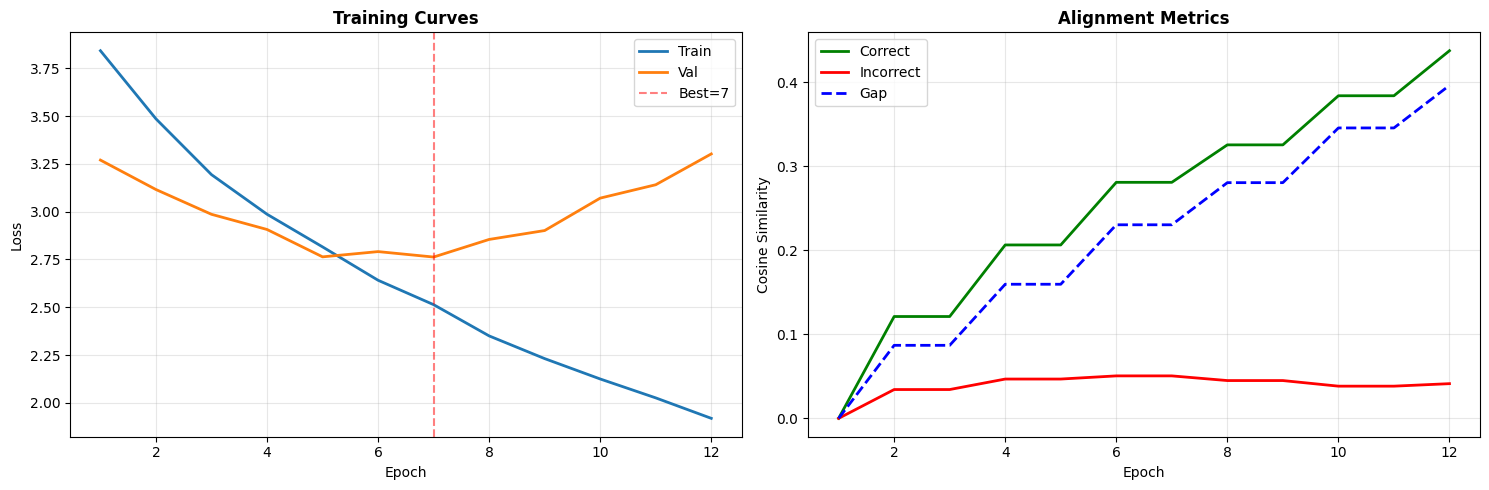


Final gap: 0.396 (target: > 0.5)
Best val loss: 2.7628 at epoch 7


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(train_losses) + 1)
axes[0].plot(epochs, train_losses, label='Train', linewidth=2)
axes[0].plot(epochs, val_losses, label='Val', linewidth=2)
axes[0].axvline(best_epoch, color='red', linestyle='--', label=f'Best={best_epoch}', alpha=0.5)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Curves', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(epochs, cos_correct_hist, label='Correct', linewidth=2, color='green')
axes[1].plot(epochs, cos_wrong_hist, label='Incorrect', linewidth=2, color='red')
gap_hist = [c - w for c, w in zip(cos_correct_hist, cos_wrong_hist)]
axes[1].plot(epochs, gap_hist, label='Gap', linestyle='--', linewidth=2, color='blue')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cosine Similarity')
axes[1].set_title('Alignment Metrics', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(pjoin(Config.SAVE_DIR, 'training_summary.png'), dpi=150)
plt.show()

print(f'\nFinal gap: {gap_hist[-1]:.3f} (target: > 0.5)')
print(f'Best val loss: {best_val_loss:.4f} at epoch {best_epoch}')

## 14. Save/Load (4 lignes classiques)

In [ ]:
# SAVE
torch.save(motion_encoder.state_dict(), pjoin(Config.SAVE_DIR, 'motion_encoder.pt'))
torch.save(text_encoder.state_dict(), pjoin(Config.SAVE_DIR, 'text_encoder.pt'))
print('✓ Models saved')

✓ Models saved


In [ ]:
# LOAD
motion_encoder.load_state_dict(torch.load(pjoin(Config.SAVE_DIR, 'motion_encoder.pt')))
text_encoder.load_state_dict(torch.load(pjoin(Config.SAVE_DIR, 'text_encoder.pt')))
print('✓ Models loaded')

✓ Models loaded


## 15. Prédiction (INCHANGÉE sauf encoder)

In [ ]:
import pathlib

TOP_K = 10
TEST_DIR = pathlib.Path(pjoin(Config.DATA_ROOT, 'val/'))

text_encoder.eval()
motion_encoder.eval()

submission_rows = []
test_subdirs = sorted([d for d in TEST_DIR.iterdir() if d.is_dir()],
                     key=lambda d: int(d.name))

with torch.no_grad():
    for sd in tqdm.tqdm(test_subdirs, desc='Génération soumission'):
        query_id = int(sd.name)

        query_file = sd / 'query.txt' if (sd / 'query.txt').exists() else sd / 'text.txt'
        query_text = query_file.read_text('utf-8').strip()
        
        text_batch = tokenize_texts([query_text])
        text_batch = {k: v.to(device) if v is not None else None for k, v in text_batch.items()}
        text_emb = encode_text(text_batch)

        candidate_files = sorted(sd.glob('motion_*.npy'))
        candidate_ids = [int(f.stem.split('_')[-1]) for f in candidate_files]

        motions, masks = [], []
        for f in candidate_files:
            m, msk = preprocess_motion(np.load(f), GLOBAL_MEAN, GLOBAL_STD)
            motions.append(m)
            masks.append(msk)

        motion_batch = torch.stack(motions).to(device)
        mask_batch = torch.stack(masks).to(device)
        motion_embs = encode_motion(motion_batch, mask_batch)
        
        if isinstance(motion_embs, tuple):
            motion_embs = motion_embs[0]

        sims = (text_emb @ motion_embs.T).squeeze(0)
        k = min(TOP_K, len(candidate_ids))
        top_idx = torch.topk(sims, k=k).indices.cpu().tolist()
        top_ids = [candidate_ids[i] for i in top_idx]

        row = {'query_id': query_id}
        for rank, mid in enumerate(top_ids, start=1):
            row[f'candidate_{rank}'] = mid
        submission_rows.append(row)

cols = ['query_id'] + [f'candidate_{k}' for k in range(1, TOP_K + 1)]
submission_df = pd.DataFrame(submission_rows).reindex(columns=cols)
submission_df.set_index('query_id', inplace=True)

submission_df.to_csv('submission.csv')
print('\n✓ submission.csv generated')
print(submission_df.head())

Génération soumission:   0%|          | 0/30 [00:00<?, ?it/s]

Génération soumission: 100%|██████████| 30/30 [00:01<00:00, 27.53it/s]


✓ submission.csv generated
          candidate_1  candidate_2  candidate_3  candidate_4  candidate_5  \
query_id                                                                    
1                  18           31            9           13            2   
2                   5           25           13           19            6   
3                  11            8           24           14           30   
4                  11           19           28           31           21   
5                   4            8           23            7           32   

          candidate_6  candidate_7  candidate_8  candidate_9  candidate_10  
query_id                                                                    
1                  26            7           14           30            24  
2                  21           20           17            7            31  
3                  17           31           12            5            20  
4                   7           24            2

## 16. Évaluation (INCHANGÉE)

In [ ]:
gt_df = pd.read_csv(pjoin(str(TEST_DIR), 'gt.csv'))
recall = eval_recall(gt_df, submission_df, verbose=True)
print(f'\n🎯 Weighted Recall: {recall:.4f}')

# Log à MLflow
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric('final_recall', recall)

k=1 => recall@1=0.3
k=2 => recall@2=0.633
k=3 => recall@3=0.633
k=4 => recall@4=0.767
k=5 => recall@5=0.8
k=6 => recall@6=0.8
k=7 => recall@7=0.833
k=8 => recall@8=0.833
k=9 => recall@9=0.867
k=10 => recall@10=0.9

🎯 Weighted Recall: 0.5880
